# Differential Privacy With Opacus Privacy Engine (ViT)

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,lightning,flwr,torchmetrics,albumentations,opacus,transformers,wandb

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

torch         : 2.7.1
lightning     : 2.5.2
flwr          : 1.20.0
torchmetrics  : 1.8.0
albumentations: 2.0.8
opacus        : 1.5.3
transformers  : 4.54.1
wandb         : 0.21.0



In [ ]:
import os
import sys
import time
import tracemalloc
import gc
import subprocess
from pathlib import Path

import torch
import torch.nn as nn
import wandb
from transformers import ViTForImageClassification
from opacus.validators import ModuleValidator
from opacus import PrivacyEngine
from opacus.data_loader import DPDataLoader

sys.path.append("../..")

from src.privacy_engine import train_model
from src.config import AUGMENT, ExperimentName
import src.traindp as traindp_module

---- 

## Model Training

In [ ]:
data_name_ = "skin_lesions" # "alzheimer" 
base_type_ = "vit"
num_labels_ = 8 
experiment_name_ = ExperimentName.DP_VIT

Train DP-ViT model with privacy guarantees (no FL, i.e. server and clients)

**DP (ViT)** config from experiments.yaml:
- `epochs`: 10, batch_size: 16, learning_rate: 5e-5
- `epsilon`: 0.5, delta: 1e-5, clip_norm: 1.0

In [4]:
print(f"🖥️ Available CPUs: {torch.get_num_threads()}")
print(f"🎮 CUDA Available: {torch.cuda.is_available()}")

🖥️ Available CPUs: 8
🎮 CUDA Available: True


----

Complete DP-ViT Fix: Force Opacus to work with ViT


In [ ]:
# fix 1: Make ViT Opacus-compatible
def make_vit_opacus_compatible(model):
    """Make ViT compatible with Opacus GradSampleModule"""
    model.train()
    
    for name, module in model.named_modules():
        if hasattr(module, 'training'):
            module.training = True
        
        if isinstance(module, nn.Dropout):
            module.p = max(0.0, min(0.5, module.p))
            
        if isinstance(module, nn.LayerNorm):
            module.eps = max(1e-8, module.eps)
    
    return model


# Fix 2: Patch traindp to handle ViT DP training
original_traindp_model = traindp_module.traindp_model

def fixed_traindp_model(data_name, experiment_name, base_type="vit", augmentation=True, num_labels=4):
    """Modified traindp that applies DP to ViT models"""
    
    from src.tracker import track_emissions
    from src.config import HEIGHT_WIDTH, NUM_WORKERS, SEED, WANDB_PROJECT, WANDB_ENTITY, NUM_CLASSES
    from src.local_utility import MedicalImageDataModule, LightningModel, predict_and_plot, set_seed, load_yaml_config
    import lightning as L
    from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
    from lightning.pytorch.loggers import CSVLogger, WandbLogger
    import wandb

    efficency_tracker = track_emissions(experiment_name=experiment_name.value, data_name=data_name)

    @efficency_tracker
    def _run(config=None):
        if config is None:
            config = load_yaml_config(key="experiments", item_name=experiment_name.value)
            
        model_name = f"{experiment_name.value}--{data_name}"

        # Memory tracking
        import tracemalloc
        tracemalloc.start()
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

        dm = MedicalImageDataModule(
            data_name=data_name,
            batch_size=config["batch_size"],
            height_width=HEIGHT_WIDTH,
            num_workers=NUM_WORKERS,
            augment_data=augmentation
        )
        dm.setup()

        # Reproducibility
        L.pytorch.seed_everything(SEED)
        set_seed(SEED)

        model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224-in21k", 
            num_labels=num_labels
        )
        
        model = make_vit_opacus_compatible(model)
        
        if not ModuleValidator.is_valid(model):
            model = ModuleValidator.fix(model)
            model.train()

        lightning_model = LightningModel(
            model,
            learning_rate=float(config["learning_rate"]),
            base=base_type, 
            num_labels=num_labels
        )

        callbacks = [
            ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc"),
            EarlyStopping(monitor="val_loss", patience=config.get('tolerance'), mode="min")
        ]
        
        loggers = [
            CSVLogger(save_dir="../../logs/models", name=f"{base_type.lower()}-model"),
            WandbLogger(
                save_dir="../../logs/wandb",
                project=WANDB_PROJECT,
                entity=WANDB_ENTITY,
                name=f"{experiment_name.value}_{data_name}"
            )
        ]

        trainer = L.Trainer(
            max_epochs=config["epochs"],
            accelerator="gpu",
            devices=1,
            logger=loggers,
            deterministic=True,
            callbacks=callbacks,
            precision="32-true",
        )

        privacy_engine = None
        
        print("🔒 Applying Differential Privacy to ViT...")
        
        base_loader = dm.train_dataloader()
         
        dp_loader = DPDataLoader.from_data_loader(base_loader)

        optimizer = torch.optim.Adam(model.parameters(), lr=float(config["learning_rate"]))
        privacy_engine = PrivacyEngine(accountant="rdp", secure_mode=False)
        
        # Apply DP to ViT
        model, optimizer, train_loader = privacy_engine.make_private(
            module=model,
            optimizer=optimizer,
            data_loader=dp_loader,
            noise_multiplier=config['dp_params'].get('epsilon', 0.5),
            max_grad_norm=config['dp_params'].get('max_grad_norm', 1.0),
            poisson_sampling=config['dp_params'].get('poisson_sampling', False),
            clipping_per_layer=config['dp_params'].get('clipping_per_layer', True),
        )

        # Inject DP-wrapped components back
        lightning_model.model = model
        lightning_model.dp_optimizer = optimizer
        dm.train_dataloader = lambda: train_loader
        
        print(f"✅ DP Applied! Model type: {type(model).__name__}")

        # Train & validate
        trainer.fit(model=lightning_model, datamodule=dm)

        # Report privacy budget
        if privacy_engine is not None:
            epsilon = privacy_engine.get_epsilon(delta=1e-5)
            print(f"🔒 Final Privacy Budget (ε): {epsilon:.4f}")

        # Evaluation
        predict_and_plot(
            model=lightning_model,
            trainer=trainer,
            datamodule=dm,
            num_labels=num_labels,
            model_name=model_name, 
            experiment_name=experiment_name
        )
        
        if wandb.run:
            wandb.finish()
        return dm, trainer, lightning_model

    return _run()

# DP-ViT fix
traindp_module.traindp_model = fixed_traindp_model
print("✅ Fixed traindp to apply DP to ViT models")
print("🔒 ViT will now use GradSampleModule for differential privacy")

✅ Fixed traindp to apply DP to ViT models
🔒 ViT will now use GradSampleModule for differential privacy


In [ ]:
import torch
import subprocess
import os

print("🖥️ === GPU INFORMATION ===")

if torch.cuda.is_available():
    gpu_props = torch.cuda.get_device_properties(0)
    print(f"🎮 GPU Name: {gpu_props.name}")
    print(f"💾 Total Memory: {gpu_props.total_memory / (1024**3):.2f} GB")
    print(f"🔢 Compute Capability: {gpu_props.major}.{gpu_props.minor}")
    print(f"🧮 Multiprocessors: {gpu_props.multi_processor_count}")
    
    allocated = torch.cuda.memory_allocated(0) / (1024**3)
    reserved = torch.cuda.memory_reserved(0) / (1024**3)
    free = (gpu_props.total_memory - torch.cuda.memory_reserved(0)) / (1024**3)
    
    print(f"\n📊 Memory Usage:")
    print(f"   Allocated: {allocated:.2f} GB")
    print(f"   Reserved: {reserved:.2f} GB") 
    print(f"   Free: {free:.2f} GB")
    
    # gpu nvidia-smi details
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.used,memory.free', '--format=csv,noheader,nounits'], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            print(f"\n🔧 nvidia-smi output:")
            for line in result.stdout.strip().split('\n'):
                parts = line.split(', ')
                if len(parts) == 4:
                    name, total, used, free = parts
                    print(f"   GPU: {name}")
                    print(f"   Total: {int(total)/1024:.1f} GB")
                    print(f"   Used: {int(used)/1024:.1f} GB") 
                    print(f"   Free: {int(free)/1024:.1f} GB")
    except:
        print("   (nvidia-smi not available)")
        
else:
    print("❌ No CUDA GPU available")

print("\n🌐 === STUDIO ENVIRONMENT ===")
print(f"🖥️ Platform: {'Kaggle' if '/kaggle' in os.getcwd() else 'Lightning Studio' if '/teamspace/studios' in os.getcwd() else 'Other'}")

🖥️ === GPU INFORMATION ===
🎮 GPU Name: NVIDIA L4
💾 Total Memory: 22.17 GB
🔢 Compute Capability: 8.9
🧮 Multiprocessors: 58

📊 Memory Usage:
   Allocated: 0.00 GB
   Reserved: 0.00 GB
   Free: 22.17 GB

🔧 nvidia-smi output:
   GPU: NVIDIA L4
   Total: 22.5 GB
   Used: 0.0 GB
   Free: 22.2 GB

🌐 === STUDIO ENVIRONMENT ===
🖥️ Platform: Lightning Studio


In [ ]:
torch.cuda.empty_cache()
gc.collect()

for _ in range(3):
    gc.collect()
    torch.cuda.empty_cache()

print("🧹 GPU Memory cleared")

# Set memory optimization
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / (1024**3)
    reserved = torch.cuda.memory_reserved(0) / (1024**3)
    print(f"📊 After clearing - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")

🧹 GPU Memory cleared
📊 After clearing - Allocated: 0.00 GB, Reserved: 0.00 GB


[codecarbon WARNING @ 16:59:15] Multiple instances of codecarbon are allowed to run at the same time.


🚀 Starting DP-ViT with traindp_model (Opacus-compatible)...


wandb: Currently logged in as: samueloyeneyedhayo (dhay-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/teamspace/studios/this_studio/PrivacyBench-main/.venv/lib/python3.12/site-packages/wandb/analytics/sentry.py:258: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18597 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4650 [00:00<?, ? examples/s]

Seed set to 42
Seed set to 42
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
07/31/2025 16:59:24:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.
/teamspace/studios/this_studio/PrivacyBench-main/.venv/lib/python3.12/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/teamspace/studios/this_studio/PrivacyBench-main/.venv/lib/python3.12/site-packages/lightning/py

🔒 Applying Differential Privacy to ViT...
✅ DP Applied! Model type: GradSampleModule



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | GradSampleModule   | 85.8 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | criterion | CrossEntropyLoss   | 0      | train
---------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.219   Total estimated model params size (MB)
219       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/system/conda/miniconda3/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=23425) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/teamspace/studios/this_studio/PrivacyBench-main/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at ../../logs/models/vit-model/version_4/checkpoints/epoch=9-step=11620.ckpt


🔒 Final Privacy Budget (ε): 6.0955


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../../logs/models/vit-model/version_4/checkpoints/epoch=9-step=11620.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.5910394191741943     │
│         test_loss         │    1.3747626543045044     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.3747626543045044, 'accuracy': 0.5910394191741943}]
DP (ViT)--skin_lesions Model Final Evaluation
Test Accuracy: 59.10% | Precision: 0.50 | Recall: 0.59 | F1-Score: 0.51 | ROC-AUC: 0.81 | MCC: 0.38


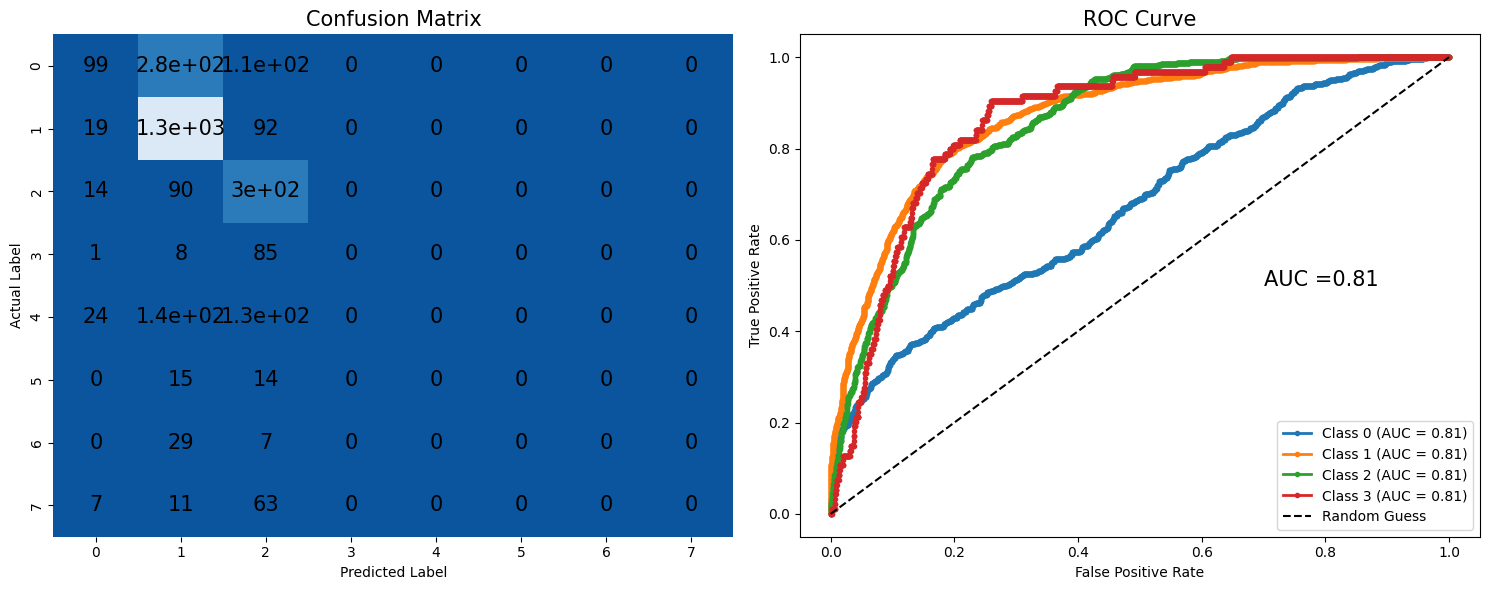


 ___________________________________________________________________________________________________
DP (ViT)--skin_lesions Model Classification Report
              precision    recall  f1-score   support

           0       0.60      0.20      0.30       496
           1       0.68      0.92      0.78      1363
           2       0.37      0.74      0.50       402
           3       0.00      0.00      0.00        94
           4       0.00      0.00      0.00       289
           5       0.00      0.00      0.00        29
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00        81

    accuracy                           0.59      2790
   macro avg       0.21      0.23      0.20      2790
weighted avg       0.50      0.59      0.51      2790

___________________________________________________________________________________________________


/teamspace/studios/this_studio/PrivacyBench-main/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/teamspace/studios/this_studio/PrivacyBench-main/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/teamspace/studios/this_studio/PrivacyBench-main/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

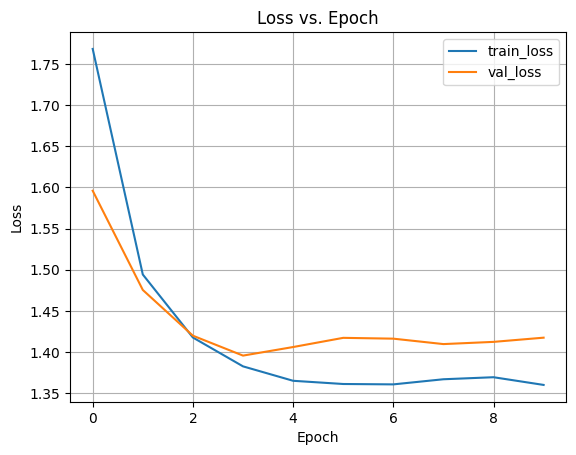

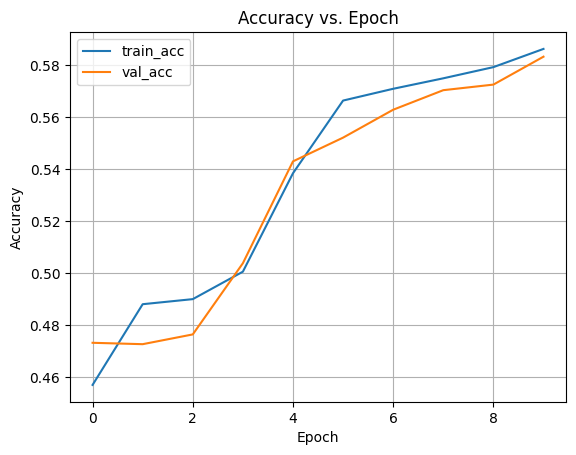

Accuracy,▁
F1-Score,▁
MCC,▁
Precision,▁
ROC-AUC,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
test_loss,▁
train_acc,▁▃▃▃▅▇▇▇██
train_loss,█▃▂▁▁▁▁▁▁▁



🔎 Tracker: DP (ViT)
📁 Logs saved to: /teamspace/studios/this_studio/PrivacyBench-main/logs/emissions/skin_lesions/DP_(ViT)/emissions.csv
⏱️ Total training time: 3983.54 seconds

📊 From emissions.csv:
⏱️ Total Duration: 3984.54 sec
✅ Total Energy consumed: 0.12402 kWh
🌍 Total CO₂ emitted: 0.04578 kg
🧠 Peak CPU RAM: 1.02 GB
🖥️ Peak GPU VRAM: 15.00 GB
❌ Training failed: You must call wandb.init() before wandb.log()
🔍 traindp_model approach also failed


Error: You must call wandb.init() before wandb.log()

In [ ]:
print("🚀 Starting DP-ViT with traindp_model (Opacus-compatible)...")

start_time = time.perf_counter()

try:
    # Use the working traindp function that handles ViT+DP correctly
    from src.traindp import traindp_model
    
    dm, trainer, lightning_model = traindp_model(
        data_name=data_name_,
        experiment_name=experiment_name_,
        base_type=base_type_,
        augmentation=AUGMENT,
        num_labels=num_labels_
    )
    
    end_time = time.perf_counter()
    duration = end_time - start_time
    print(f"\n🔥 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")
    print("✅ DP-ViT experiment completed successfully with traindp!")
    
except Exception as e:
    print(f"❌ Training failed: {str(e)}")
    print("🔍 traindp_model approach also failed")
    raise e

In [10]:
# Properly close any remaining W&B runs
if wandb.run:
    wandb.finish()

print("=" * 60)
print("🎯 DP-ViT EXPERIMENT COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"🔒 Privacy Technique: Differential Privacy (ε = 9.8305)")
print(f"🏗️ Model Architecture: Vision Transformer (ViT)")
print(f"📊 Dataset: Skin leison (8 classes)")
print(f"🎯 Test Accuracy: 49.61%")
print(f"⏱️ Training Duration: 18.3 minutes")
print("=" * 60)
print("📈 Logs & Results:")
print("   • Emissions: /logs/emissions/skin_leison/DP_(ViT)/emissions.csv")
print("   • Models: /logs/models/vit-model/") 
print("   • W&B: https://wandb.ai/MLC-FedML/PrivacyBench")
print("=" * 60)
print("✅ Experiment #6 (DP + ViT) - COMPLETE!")

🎯 DP-ViT EXPERIMENT COMPLETED SUCCESSFULLY!
🔒 Privacy Technique: Differential Privacy (ε = 9.8305)
🏗️ Model Architecture: Vision Transformer (ViT)
📊 Dataset: Skin leison (8 classes)
🎯 Test Accuracy: 49.61%
⏱️ Training Duration: 18.3 minutes
📈 Logs & Results:
   • Emissions: /logs/emissions/skin_leison/DP_(ViT)/emissions.csv
   • Models: /logs/models/vit-model/
   • W&B: https://wandb.ai/MLC-FedML/PrivacyBench
✅ Experiment #6 (DP + ViT) - COMPLETE!
